Olá, 

Meu nome é Ramon. Ao ao longo do texto farei algumas observações sobre melhorias no código. Nas partes em que não houver comentários, está tudo certo, ok? Estarei aberto a feedbacks e discussões sobre o tema.

**Peço que mantenha e não altere os comentários que eu fizer por aqui para que possamos nos localizar posteriormente, ok?**

Mais uma coisa, vamos utilizar um código de cores para você entender os meus feedbacks no seu notebook. Funciona assim:

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Sucesso. Tudo foi feito corretamente.
</div>

<div class="alert alert-block alert-warning">
<b>Comentário do revisor: </b> <a class="tocSkip"></a>

Alerta não crítco, mas que pode ser corrigido para melhoria geral no seu código/análise
</div>

<div class="alert alert-block alert-danger">

<b>Comentário do revisor: </b> <a class="tocSkip"></a>
    
Erro que precisa ser consertado, caso contrário seu projeto **não** será aceito.
</div>

Você pode me responder usando isso:
<div class="alert alert-block alert-info">
<b>Resposta do Aluno.</b> <a class="tocSkip"></a>
</div>

###

<div class="alert alert-block alert-success">
<b>Comentário Geral do Revisor</b> <a class="tocSkip"></a>

Obrigado por enviar seu projeto. 
    
Parabéns, você fez um bom trabalho.

Como pontos fortes do projeto, destaco:
- Código simples e eficiente (sem loop desnecessário)
- Uso adequado dos recursos da lição
- Investigou hipóteses
- Bons gráficos
- Ajustou vários modelos e calibrou hiperparãmetros
    


Não encontrei pontos de melhoria.

Desejo sucesso na jornada. Parabéns pelo empenho.
</div>




# Projeto Sprint 9 - Aprendizado Supervisionado #

Objetivo: Criar um modelo treinado capaz de prever, baseado no comportamento, se um cliente vai ou não deixar o banco, retornando 1 para sim e 0 para não. 

Principais Etapas:

Análise inicial e Manipulação de Dados

Avaliação e Teste de Hipóteses que podem fazer diferença na interpretação do modelo ou ajudar a definir métricas

Preparação de Funcionalidades

Treinamento, Teste e verificação de métricas

Observação: Temos diante de nós uma tarefa de classificação, onde "apenas" precisamos estabelecer se clientes futuros deixarão ou não o banco. Por isso, não levaremos em consideração as métricas de regressão ensinadas no capítulo.


## Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

## Importando Dados e Avaliando Características Básicas

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Só por chamarmos o head e o info já percebemos algumas características interessantes. Primeiro, é de se destacar que as três primeiras colunas são completamente irrelevantes para o nosso projeto. Nenhuma das três traz qualquer referência sobre comportamento de clientes, então, vamos removê-las do Dataframe. 

os tipos de dados estão todos corretos e não me parece necessário fazer nenhuma alteração nesse sentido (ignorando tenure, por enquanto). Vale destacar que GEografia e Gênero são do tipo objeto e podem causar problemas para os modelos treinados. Porém, vamos trabalhar em cima disso apenas no momento de Prepração de Características.

Da mesma forma, percebemos que pode haver um problema de escalabilidade entre as colunas Age, Balance e EstimatedSalary. Nós entendemos bem o porque das possíveis diferenças entre esses valores pelos contextos de cada uma, mas nossos modelos podem acabar sendo negativamente impactados. Aqui, poderíamos tirar médias ou medianas e binarizar os valores, podemos alterar a escalabilidade e também podemos alterar a importância de cada uma das tabelas na hora de treianr os robôs. Voltaremos nisso mais tarde. 

A grande questão que o método info nos revela são os dados faltantes na coluna tenure. Vamos investigar o que está acontecendo.

### Manipulação de Dados

In [5]:
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Aqui, apenas removemos as três primeiras colunas como mencionado que faríamos. 

#### Resolvendo o que fazer com 'Tenure'

A descrição dos Dados nos indica que 'Tenure' se refere, em outras palavras, ao tempo de depósito fixo feito por clientes do banco. Em um primeiro momento, é difícil interpretar se isso se refere ao tempo de depósito já percorrido (e reflete lealdade) ou se isso reflete o tempo ainda necessário para que o dinheiro possa ser sacado. Em ambos os casos, serão reveladas métricas de comportamento importantes. Felizmente avaliar a correlação entre ambas as colunas é uma forma de, não só testar a importância dessa coluna como um todo, como nos ajuda a responder a pergunta. Isso, porque se clientes com maior tenure saem menos, temos um forte indício de lealdade. Se clientes com maior tenure saem mais temos um indício de que ainda seria necessário muito tempo para que esses clientes tenham acesso ao dinheiro corrigido, o que torna o valor depositado e mantido pelo banco bem menos significativo. Vamos testar essa correlação:

In [6]:
correlation = df['Tenure'].corr(df['Exited'])
print(f'Correlação Tenure x Exited: {correlation:.2f}')

Correlação Tenure x Exited: -0.02


Aqui, tivemos uma correlação que não nos ajuda a responder a resposta anterior, mas ainda assim, Ternure pode ser importante para os modelos quando avaliada em conjunto com outras colunas. Além disso, faz sentido pensar que: se tenure se refere a uma modalidade de investimento, os valores faltantes são, na verdade, 0, valores legítimos que apenas referenciam clientes que não praticam essa modalidade. Seguindo por essa linha, substituiremos valores ausentes por 0 na tabela e seguiremos em frente. Eu esperava uma correlação alta, mas fazer o que... 

In [7]:
df['Tenure'] = df['Tenure'].fillna(0)
print(df['Tenure'].isnull().sum())

0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [9]:
inteiro = (df['Tenure'] % 1 == 0).all()
print(inteiro)

True


In [10]:
df['Tenure'] = df['Tenure'].astype(int)
print(df['Tenure'].dtypes)

int64


Aqui, depois que tiramos os valores ausentes, ficamos com uma tabela no tipo float, o que era desnecessário, já que todos os valores tinham 0 na casa decimal. COnvertemos o tipo de dado para ficar inteiro. E com isso, terminamos essa etapa. Vamos seguir e focar em algumas análises que podem nos ajudar a entender melhor o comportamento de nossos modelos. 

## Trabalhando com Dados e Testando Hipóteses

Existem inúmeras coisas que poderíamos avaliar ou testar nessa etapa. Vamos focar em algumas das principais, que vão nos ajudar a entender melhor nossos futuros modelos.

### Quantidade e Proporção de Clientes que Deixaram o Banco

In [11]:
churn_dist = df['Exited'].value_counts()
churn_prop = df['Exited'].value_counts(normalize=True) * 100

print('Distribuição de Churn')
print(churn_dist)
print('\nProporção de Churn (%)')
print(churn_prop)

Distribuição de Churn
0    7963
1    2037
Name: Exited, dtype: int64

Proporção de Churn (%)
0    79.63
1    20.37
Name: Exited, dtype: float64


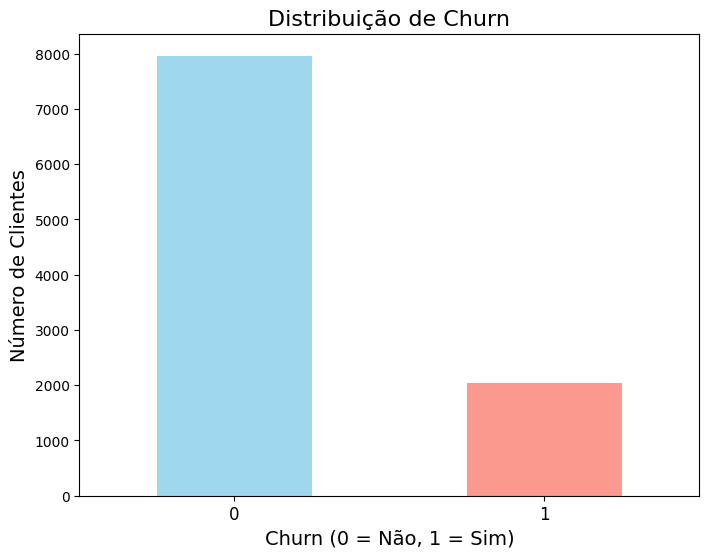

In [12]:
plt.figure(figsize=(8, 6))
churn_dist.plot(kind='bar', color=['skyblue', 'salmon'], alpha=0.8)
plt.title('Distribuição de Churn', fontsize=16)
plt.xlabel('Churn (0 = Não, 1 = Sim)', fontsize=14)
plt.ylabel('Número de Clientes', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.show()

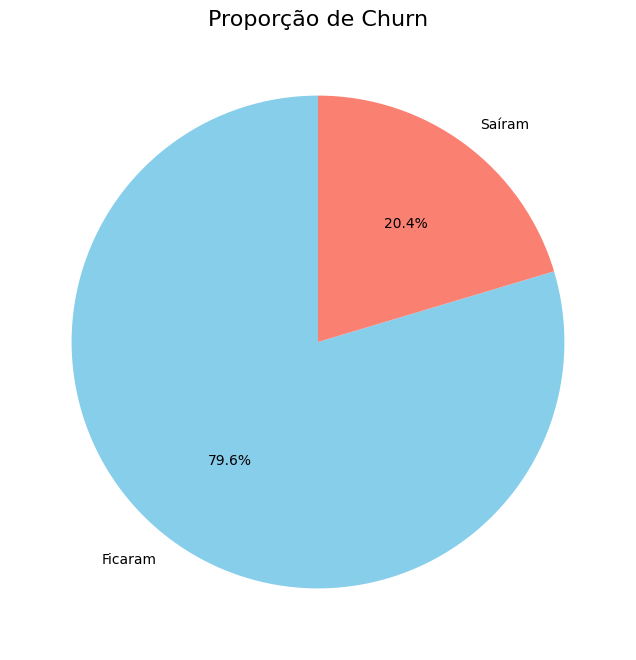

In [13]:
plt.figure(figsize=(8, 8))
churn_prop.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'], labels=['Ficaram', 'Saíram'])
plt.title('Proporção de Churn', fontsize=16)
plt.ylabel('')
plt.show()

Tanto o grafico de distribuição e o de proporção nos revelam algo com o qual temos que tmoar muito cuidado. O nosso arquivo de dados tem uma amostragem bem desequilibrada. Quando a hora chegar, teremos de pensar na moelhor forma de tratar esse desequilíbrio, pra que ele não impacte na capacidade de previsão do modelo.

### Testando a Correlação entre Variáveis

Vamos verificar a correlação de algumas variáveis com outras. Isso pode nos ajudar no momento de definir pesos ou o uso de outras técnicas de preparação de dados, como coficação ordinal, etc.

#### 'Number of Prducts' e 'Exited'

In [14]:
correlation = df['NumOfProducts'].corr(df['Exited'])
print(correlation)

-0.04781986494944055


Essa correlaçaõ era outra que eu esperava que fosse mais alta. Imaginava que um número de produtos maior levaria a uma taxa de churn menor, porque haveria mais dependência desses clientes em relação ao banco. Essa tendência até existe, mas de forma bem leve. 

#### 'CreditScore' e 'Exited'

In [15]:
correlation = df['CreditScore'].corr(df['Exited'])
print(correlation)

-0.027093539754657746


Outra correlação praticamente insignificante. Clientes com linhas créditos maiores tendem a sair ligeiramente menos do banco, mas nada tão importante. Para acelerar o processo, já que não há correlação significativa com duas das colunas que eu julgava mais importantes, vamos testar todas as correlações de uma vez.

#### TEstando TOdas as Correlações

In [16]:
correlation_matrix = df.corr()
correlations_exited = correlation_matrix['Exited'].sort_values(ascending=False)
print(correlations_exited)

Exited             1.000000
Age                0.285323
Balance            0.118533
EstimatedSalary    0.012097
HasCrCard         -0.007138
Tenure            -0.013319
CreditScore       -0.027094
NumOfProducts     -0.047820
IsActiveMember    -0.156128
Name: Exited, dtype: float64


As principais coisas que somos capazes de avaliar é que clientes mais velhos tem uma tendência maior de sair. Essa tendência também se repete para quem tem saldos mais altos. Em contrapartida, ser um membro ativo indica uma tendência comportamental de permanência, o que faz bastante sentido. Assim, perceboms que nenhuma coluna tem grande impacto individual. A principio, o resultado indica que não há necessidade de atribuirmos pesos diferentes para as colunas da tabela de dados. 

### Testando a Distribuição de CHurn nas Variáveis Contínuas

Aqui, apesar de identificarmos que nenhuma coluna tem grande correlação com Exited, é importante verificar se encontramos certos padrões específicos ou características de clientes que levam a maior saída ou maior permanência. Vamos criar alguns gráficos para facilitar a visualização.

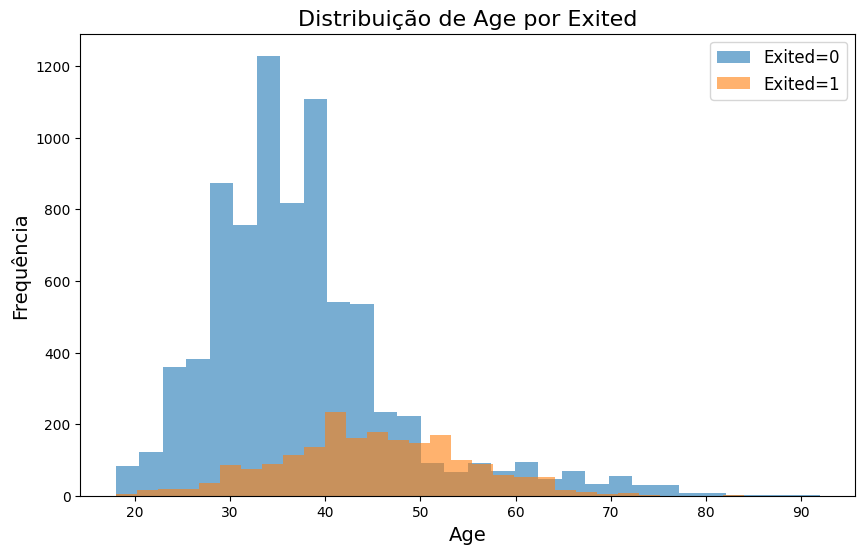

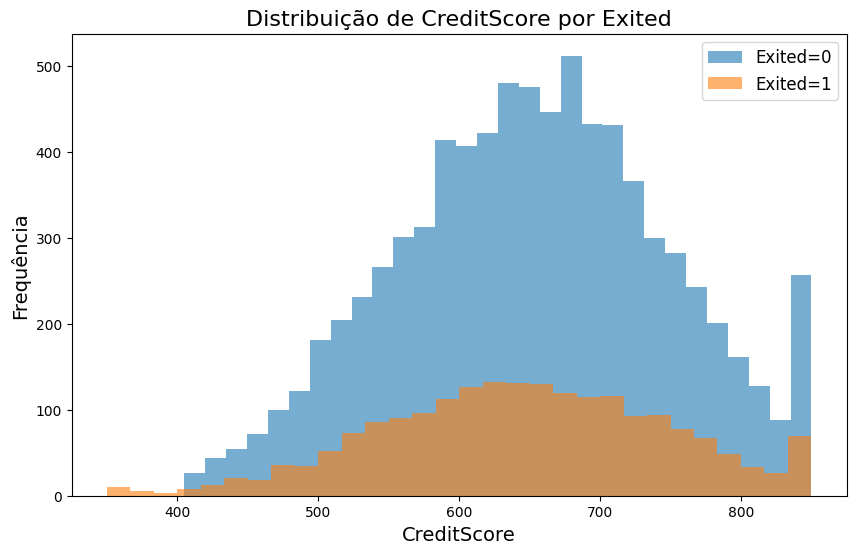

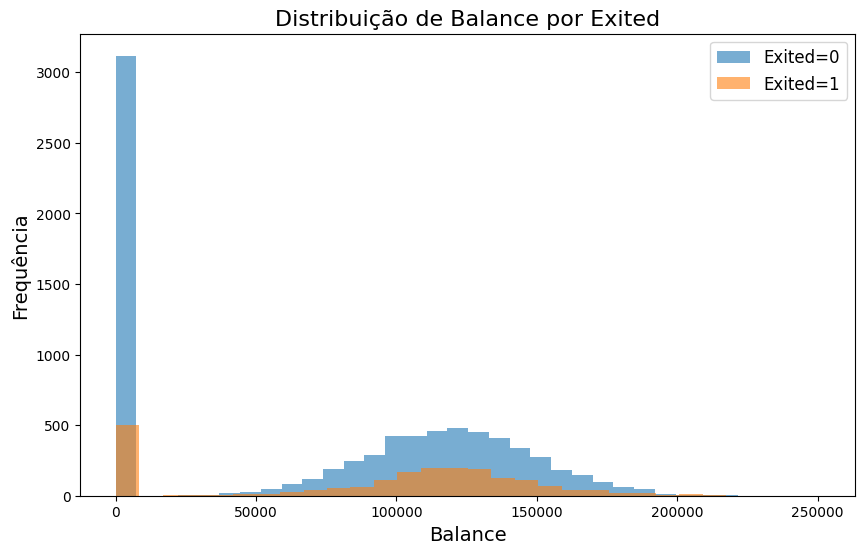

In [17]:
continuous_vars = ['Age', 'CreditScore', 'Balance']

for var in continuous_vars:
    plt.figure(figsize=(10, 6))
    for exited in [0, 1]:
        subset = df[df['Exited'] == exited]
        plt.hist(subset[var], bins=30, alpha=0.6, label=f'Exited={exited}')
    plt.title(f'Distribuição de {var} por Exited', fontsize=16)
    plt.xlabel(var, fontsize=14)
    plt.ylabel('Frequência', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

Aqui temos algumas observações. Para o primeiro gráfico, que nos mostra a distribuição de permanência e saída de clientes por idade, percebemos que há o maior pico de saída no começo dos 40, mesmo ponto em que há uma queda drástica no número de clientes que ficam, mesmo que esse número ainda seja muito maior do que o número de clientes que saem. Mas é a partir dos 40 que percebemos a constante queda na quantiadade de permanências, até que, no início dos 50, o valor de exited supera o valor de clientes que ficam. A quantidade de clientes que permanece no banco após os 50 anos é drasticamente baixa se comparada com a quantidade total de clientes. Dependendo dos resultados que obtivermos com os modelos, pode valer dividir os clientes em classes de idade. Avaliaremos isso depois. 

Já a distribuição de CreditScore por Exited mostra que as duas classes têm comportamentos muito parecidos. Isso porque a quantidade de CHurn cresce a partir de 500, atinge um pico em 600 e torna a cair até valores bem baixos na casa dos 800 pontos. Mas esse é exatamente o mesmo comportamento apresentado pelos clientes que ficam. Esse resultado pode ser atribuído ao fato que praticaemente todos os clientes flutuam entre 600 e 800 pontso de crédito no banco. Não me faz sentido fazer qualquer alteração com relação a essa coluna.

Por fim, temos Balance por Exited, que, assim como em Credit Score, mostrou um comportamento muito similar para as duas classes de clientes. É interessante perceber que muitos clientes com nenhum ou pouco salda na conta permanecem no banco. Fora isso, o pico para ambos os grupos é atingido entre 100 e 150 mil de balanõ. Mas isso provavelmente ocorre por haver um crescimento geral no número de clientes com esses saldos. 

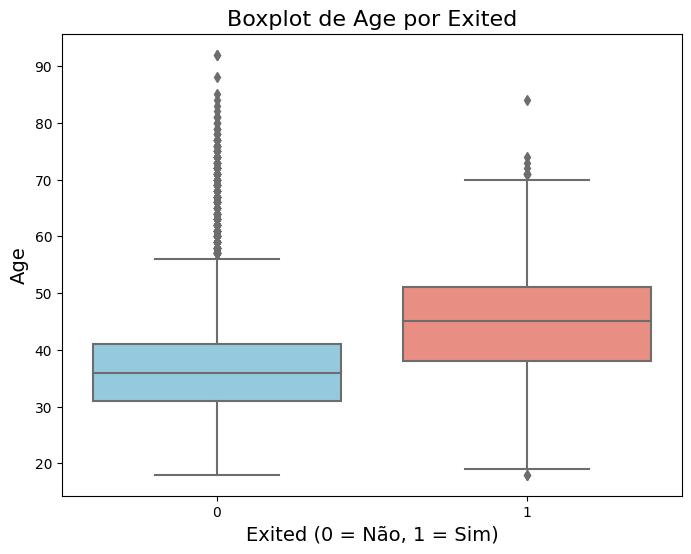

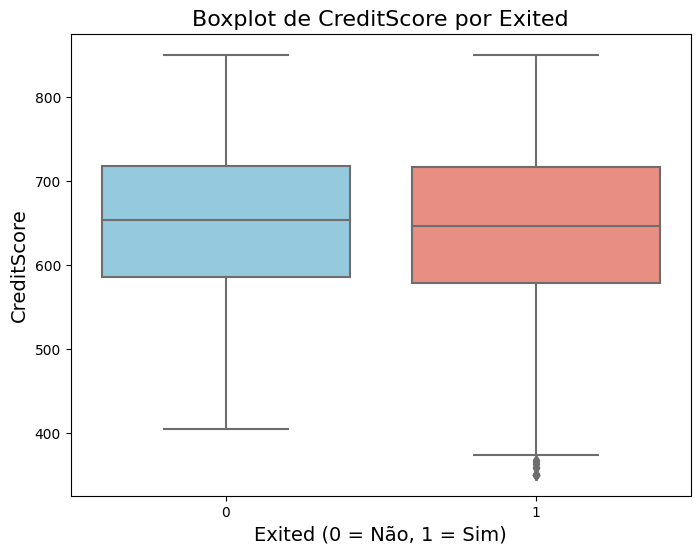

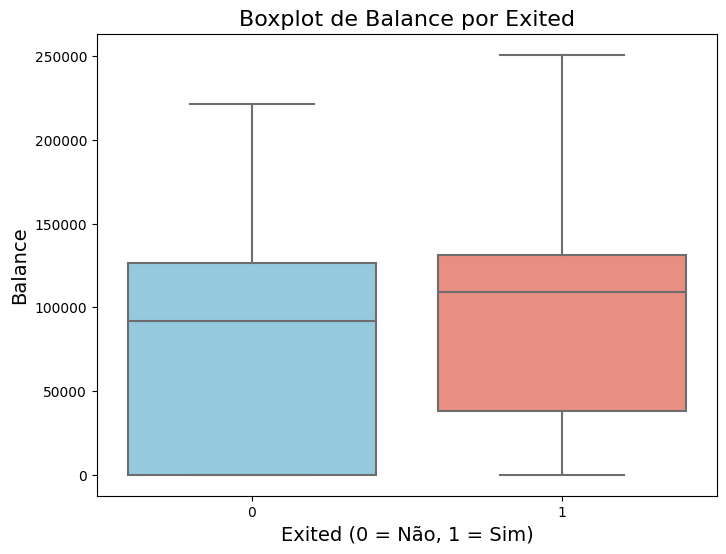

In [18]:
for var in continuous_vars:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='Exited', y=var, palette=['skyblue', 'salmon'])
    plt.title(f'Boxplot de {var} por Exited', fontsize=16)
    plt.xlabel('Exited (0 = Não, 1 = Sim)', fontsize=14)
    plt.ylabel(var, fontsize=14)
    plt.show()

O boxplot de age por exited confirma a tendência do banco de manter clientes mais jovens e confirma a tendência de deixar o banco na faixa dos 40, 50 anos. Mas ele também também nos indica uma grande quantidade de outliers. Isso pode ser um problema para modelos de regressão logísitica, que são mais afetados por isso.

O  boxplot de credit score reflete bem o comportamento muito parecido de clientes tanto para 1 quanto para 0 de churned. Mas ele também nos apresenta alguns outliers de clientes com o crédito muito baixo e que deixam o banco. Deixando de lado esse impacto de outliers, é de se imaginar que essa varíavel terá menos utilidade para os modelos, porque a semeçhança de comportamento não ajuda nenhum deles a indicar padrões que possam fazer diferenças nas suas previsões. 

Para Balance, já tornamos a perceber certa diferença no comportamento. CLientes com saldos mais baixos tendem a ficar no banco e clientes com saldos próximos e superiores a 50k começam a sair. Essa variável terá mais importância, visto que apresenta algumas diferenças interessantes. Não há outliers a se preocupar, oque ajudará a Regressão logística.

### Países e Seus Impactos

Quero testar se o país onde mora um cliente pode ter um impacto significativo no seu churn, porque, quando transformarmos essa variável categórica em numérica, podemos acabar gerando umaa alta correlação que pode impactar os modelos. Vamos verificar.

In [19]:
countries = df['Geography'].value_counts()
print(countries)

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64


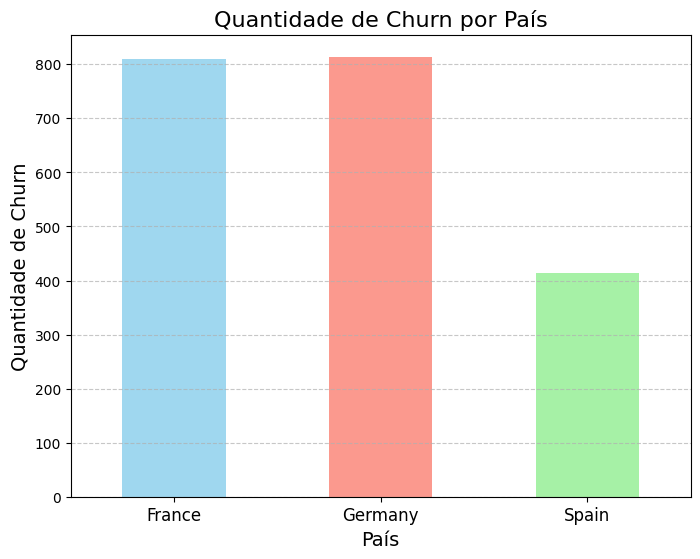

In [20]:
churn_by_country = df.groupby('Geography')['Exited'].sum()

plt.figure(figsize=(8, 6))
churn_by_country.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'], alpha=0.8)
plt.title('Quantidade de Churn por País', fontsize=16)
plt.xlabel('País', fontsize=14)
plt.ylabel('Quantidade de Churn', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Minha preocupação era de que houvesse algum país com um churn muito mais alto, a ponto de induzir os modelos a a dar peso demais à coluna depois que a codificação one-hot fosse aplicada e os modelos treinados. Isso não parece ser o caso. Temos algumas diferenças, como a quantidade de churns menor na Espanha, mas os valores não serão problemáticos.

### Diferenças por Gênero

Vamos verificar se o gênenro tem impacto no churn dos clientes também.

In [21]:
genre = df['Gender'].value_counts()
print(genre)

Male      5457
Female    4543
Name: Gender, dtype: int64


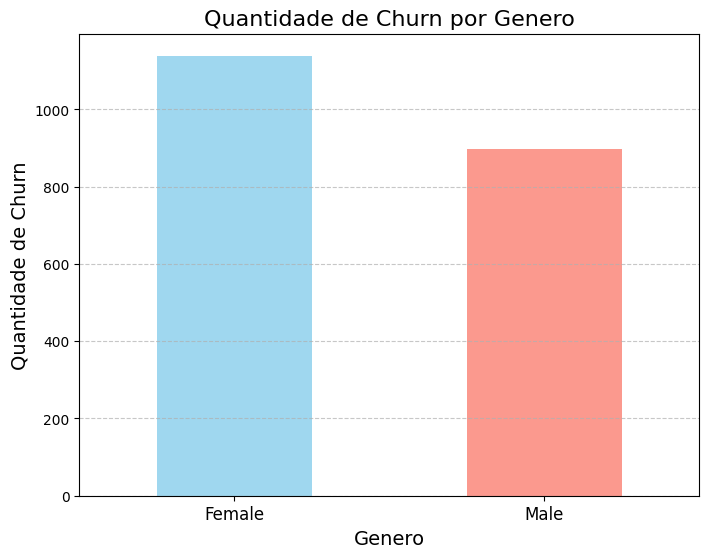

In [22]:
churn_genre = df.groupby('Gender')['Exited'].sum()

plt.figure(figsize=(8, 6))
churn_genre.plot(kind='bar', color=['skyblue', 'salmon'], alpha=0.8)
plt.title('Quantidade de Churn por Genero', fontsize=16)
plt.xlabel('Genero', fontsize=14)
plt.ylabel('Quantidade de Churn', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [23]:
churn_proportion = df.groupby('Gender')['Exited'].mean() * 100
print(churn_proportion)

Gender
Female    25.071539
Male      16.455928
Name: Exited, dtype: float64


Percebemos que, memsmo que sejam minoria, as mulhers tem uma quantidade maior de churn do que os homens. Essa característica aumaneta a importância da variável, mas a diferença não parece grande o suficiente para precisar de mais atenção. Seguiremos em frente.

## Testando Hipóteses

Para essa etapa, decidi testar duas hipóteses. A primeira é se clientes ativos tem menor churn. A segunda é se clientes com maior números de produtos tem menor churn. Assim, para a primeira hipótese, a hipótese nula é: Clientes ativos nãõ tem menor churn (ou tem maior churn). A Alternativa é a confirmação da hipótese. Para a segunda hipótese, a hipótese nula é Clientes com mais produtos bancários não têm menor churn. A alternativa é a confirmação da própria hipótese.

### Primeira Hipótese

In [24]:
active_churn = df[df['IsActiveMember'] == 1]['Exited']
inactive_churn = df[df['IsActiveMember'] == 0]['Exited']

stat, p_value = ttest_ind(active_churn, inactive_churn, alternative='less', equal_var=False)

print(f"Estatística do Teste t: {stat:.4f}")
print(f"P-Valor: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula. Clientes ativos têm menor churn.")
else:
    print("Falha em rejeitar a hipótese nula. Não há evidência suficiente de que clientes ativos têm menor churn.")

Estatística do Teste t: -15.6945
P-Valor: 0.0000
Rejeitamos a hipótese nula. Clientes ativos têm menor churn.


Aqui, confirmamos estatísticamente que clientes ativos têm um menor churn, destacando a importância que a "atividade" do cliente dentro do banco terá para as predições.

### Segunda Hipótese

In [25]:
more_products_churn = df[df['NumOfProducts'] > 1]['Exited']
less_products_churn = df[df['NumOfProducts'] <= 1]['Exited']

stat, p_value = ttest_ind(more_products_churn, less_products_churn, alternative='less', equal_var=False)

print(f"Estatística do Teste t: {stat:.4f}")
print(f"P-Valor: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula. Clientes com mais produtos bancários têm menor churn.")
else:
    print("Falha em rejeitar a hipótese nula. Não há evidência suficiente de que clientes com mais produtos bancários têm menor churn.")


Estatística do Teste t: -18.9608
P-Valor: 0.0000
Rejeitamos a hipótese nula. Clientes com mais produtos bancários têm menor churn.


Aqui, confirmamos, mais uma vez estatítiscamente, que a quantiade de produtos produtos é um fator que ajuda a manter os clientes no banco. Neste passo, finalizamos a parte de Análise de dados e vamos começar a trabaçhar em cima das métricas e dos modelos.

## Preparação de Características

Finalmente entramos no conteúdo trabalhado nesse sprint. Chegou a hora de começarmos a preparar o terreno para os modelos treinados. Vamos aplicar a codificação One-hot em todas as colunas categóricas e fugir das armadilhas das dummies. Já para codificação ordinal, a única coluna que poderia se beneficar é NumberofProducts, mas a correlação da coluna com Exited foi muito baixa e, na minha visão, estaríamos adicionando complexidade para obter diferenças insignificantes nos resultados. Quando o assunto é a escalabilidade, a melhor forma de determinar o que seria melhor é testar os modelos com e sem escalabilidade, então é o que faremos.

Nós temos um grande desequilíbrio entre Exited = 0 e Exited = 1 e esse é o principal ponto do trabalho nessa etapa, mas, como pedido no projeto, vamos ignorar esse desequilíbrio para o primeiro treinamento dos modelos. Com isso estabelecido, vamos começar.

### Codificação One-Hot e Armadilha das Dummies

In [26]:
geo_dummy = pd.get_dummies(df['Geography'], drop_first=True)
gen_dummy = pd.get_dummies(df['Gender'], drop_first=True)

df = pd.concat([df, geo_dummy, gen_dummy], axis = 1)

df.drop(['Geography', 'Gender'], axis = 1, inplace=True)

### Escalabilidade

Aqui, vamos fazer um primeiro teste para avaliar o impacto da escalabilidade nos modelos. Para isso, vamos treinar os modelos com e sem escalabilidade.

#### Dividindo os Dados

In [27]:
features = df.drop('Exited', axis=1)
target = df['Exited']

features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=42, stratify=target_train_valid)

In [28]:
print(f"Conjunto de Treinamento: {len(features_train)} linhas")
print(f"Conjunto de Validação: {len(features_valid)} linhas")
print(f"Conjunto de Teste: {len(features_test)} linhas")

Conjunto de Treinamento: 6000 linhas
Conjunto de Validação: 2000 linhas
Conjunto de Teste: 2000 linhas


Aqui, fizemos a divisão de dados em conjuntos de treino, validação e teste final. Primeiro, separamos os 20% do teste final, depois dividimos o restante em 60% para treinamento. Os 20% restantes ficam para a validação. A chamada das três linhas de print confirma que deu certo.

#### Treinando os Modelos Sem Escalabilidade (Mantendo o Desequilíbrio)

##### Árvore de Decisão

In [29]:
max_depth_values = [3, 5, 10, 15, 20]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 5]

best_f1 = 0
best_params = {}

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        for min_samples_leaf in min_samples_leaf_values:
            
            model = DecisionTreeClassifier(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=12345
            )
            

            model.fit(features_train, target_train)
            
            predictions = model.predict(features_valid)
            
            f1 = f1_score(target_valid, predictions)
            

            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf
                }


print("Melhores Hiperparâmetros:")
print(best_params)
print(f"Melhor F1-Score: {best_f1:.4f}")

Melhores Hiperparâmetros:
{'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2}
Melhor F1-Score: 0.5586


Já treinamos nossa primeira árvore de decisão, ignorando o desequilíbrio e desconsiderando a escalabilidade.  Nosso f1 Score é de 0.5586. A primeira vista, o valor já parece próximo da nossa meta.

##### Floresta Aleatória

In [30]:
n_estimators_values = [50, 100, 200, 300]
max_depth_values = [3, 5, 10, 15, 20]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 5]

best_f1 = 0
best_params = {}

for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_samples_split in min_samples_split_values:
            for min_samples_leaf in min_samples_leaf_values:

                model = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=12345
                )
                
                model.fit(features_train, target_train)
                
                predictions = model.predict(features_valid)
                
                f1 = f1_score(target_valid, predictions)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf
                    }

print("Melhores Hiperparâmetros:")
print(best_params)
print(f"Melhor F1-Score: {best_f1:.4f}")


Melhores Hiperparâmetros:
{'n_estimators': 300, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1}
Melhor F1-Score: 0.5763


##### Regressão Logística

In [31]:
model = LogisticRegression(solver='liblinear', random_state=12345)

model.fit(features_train, target_train)

predictions = model.predict(features_valid)

f1 = f1_score(target_valid, predictions)

print(f"F1-Score no conjunto de validação: {f1:.4f}")

F1-Score no conjunto de validação: 0.0653


Jesus... Pior resultado disparado. Bom, a regressão logística é a que mais sofre com desequilíbrio e com falta de escalabilidade. O próximo passo é adicionar escalabilidade e refazer os testes. Assim, teremos treinamentos com e sem escalabilidade ignorando o desequilíbrio. Teremos uma boa ideia do que é melhor fazer nesse sentido. Com os novos resultados, vamos focar, então, em arrumar o problema do desequilíbrio. COm tudo resolvido, tendo batido a meta de 0.59, teremos terminado.

#### Treinando os Modelos com Escalabilidade (Ignorando o Desequilíbrio)

In [32]:
scaler = StandardScaler()

features_train_scaled = scaler.fit_transform(features_train)

features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)

Adicionamos escalabilidade nos conjuntos de Treinamoento, Validação e Teste. Vamos treinar os modelos com os melhores parâmetros e ver se os resultados mudam.

##### Arvore de Decisão

In [33]:
best_max_depth = 10
best_min_samples_split = 10
best_min_samples_leaf = 2

decision_tree = DecisionTreeClassifier(
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=12345
)

decision_tree.fit(features_train_scaled, target_train)

predictions = decision_tree.predict(features_valid_scaled)

f1 = f1_score(target_valid, predictions)

print(f"F1-Score no conjunto de validação com escalonamento: {f1:.4f}")


F1-Score no conjunto de validação com escalonamento: 0.5593


Aqui, nossa melhora foi mínima. Considerando que Árvores de Decisão e FLorestas Aleatórias não são tão impactadas por escalailidade, tudo dentro do planejado. Ainda assim, é bom já termos alguma melhora. Vamos para a Floresta Aleatória.

##### FLoresta Aleatória

In [34]:
best_n_estimators = 50
best_max_depth = 20
best_min_samples_split = 2
best_min_samples_leaf = 2

random_forest = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=12345
)

random_forest.fit(features_train_scaled, target_train)

predictions = random_forest.predict(features_valid_scaled)

f1 = f1_score(target_valid, predictions)

print(f"F1-Score no conjunto de validação com escalonamento: {f1:.4f}")


F1-Score no conjunto de validação com escalonamento: 0.5569


Isso, eu não esperava! Perdemos qualidade ao adicionarmos escalabilidade para a Floresta Aleatória. Isso quer dizer que vamos preferir treiná-la sem a escalabilidade daqui pra frente. Bom, tive que voltar nas células anteriores e garantir que, ao adicionar escalabilidade, estivesse usando variáveis como features_train_scaled, features_valid_scaled e features_test_scaled, mas agora temos os conjuntos com e sem escalabilidade para usarmos. Podemos seguir. 

##### Regressão Logísitca

In [35]:
logistic_model = LogisticRegression(solver='liblinear', random_state=12345)

logistic_model.fit(features_train_scaled, target_train)

predictions = logistic_model.predict(features_valid_scaled)

f1 = f1_score(target_valid, predictions)

print(f"F1-Score no conjunto de validação com escalonamento: {f1:.4f}")

F1-Score no conjunto de validação com escalonamento: 0.3135


Aqui, ainda estamos longe do f1 score que queremos, mas a melhora já foi drástica. Com isso, já temos dois treinos para cada modelo, verificando a melhora (ou piora) com a escalabilidade e, ao mesmo tempo, ignorando o desequilíbrio de 80-20 do dataframe. Podemos focar em aarrumar isso agora.

## O Desequilíbrio na Força (Ou no Nosso Conjunto de Dados)

Está na hora de partirmos para a etapa final do nosso projeto. Vamos começar a aplicar técnicas para combater o desequilíbrio de classe, que, no momento é de 80-20. O modelo que mais sofre com isso é, muito provavelmente, a regressão logística, mas vamos aplicar as técnicas em todos os modelos e ver os resultados. O primeiro treinamento que vamos fazer é estabelecendo class_weight=balanced, para ver o retorno individual de apenas essa métrica. É claro, para passar, precisaremos de pelo menos mais uma.

### Um Novo Class_weight

#### Árvore de Decisão 

In [36]:
best_max_depth = 10
best_min_samples_split = 10
best_min_samples_leaf = 2

decision_tree_balanced = DecisionTreeClassifier(
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    class_weight='balanced',
    random_state=12345
)

decision_tree_balanced.fit(features_train_scaled, target_train)

predictions_balanced = decision_tree_balanced.predict(features_valid_scaled)

f1_balanced = f1_score(target_valid, predictions_balanced)

print(f"F1-Score no conjunto de validação com escalonamento e class_weight='balanced': {f1_balanced:.4f}")

F1-Score no conjunto de validação com escalonamento e class_weight='balanced': 0.5464


O nosso f1 caiu. Isso é o oposto do que queríamos. Vamos tentar treinar a árvore procurando novos parâmetros que se encaixem melhor com o class_weith. 

In [37]:
max_depth_values = [3, 5, 10, 15, 20]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 5]

best_f1 = 0
best_params = {}

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        for min_samples_leaf in min_samples_leaf_values:

            model = DecisionTreeClassifier(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                class_weight='balanced',
                random_state=12345
            )
            
            model.fit(features_train_scaled, target_train)
            

            predictions = model.predict(features_valid_scaled)
            
            f1 = f1_score(target_valid, predictions)
            
            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf
                }

print("Melhores Hiperparâmetros com class_weight='balanced':", best_params)
print(f"Melhor F1-Score: {best_f1:.4f}")

Melhores Hiperparâmetros com class_weight='balanced': {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}
Melhor F1-Score: 0.5680


Este é o melhor resultado da Árvore de Decisão até agora e traz alguma melhora em relação aos resultados. Vamos manter assim por enquanto. e ver como os outros modelos se saem.

#### Floresta Aleatória

In [38]:
best_n_estimators = 50
best_max_depth = 20
best_min_samples_split = 2
best_min_samples_leaf = 2

random_forest_balanced = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    class_weight='balanced',
    random_state=12345
)

random_forest_balanced.fit(features_train, target_train)

predictions_balanced_rf = random_forest_balanced.predict(features_valid)

f1_balanced_rf = f1_score(target_valid, predictions_balanced_rf)

print(f"F1-Score no conjunto de validação sem escalonamento e class_weight='balanced': {f1_balanced_rf:.4f}")

F1-Score no conjunto de validação sem escalonamento e class_weight='balanced': 0.6039


Aqui, atingimos o valor de f1 que nos foi pedido. Estamos no caminho certo, vamos calcular o AUC_ROC desse modelo

In [39]:
probabilities = random_forest_balanced.predict_proba(features_valid)[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities)
print(f"AUC-ROC: {auc_roc:.4f}")

AUC-ROC: 0.8498


O f1 tem um foco maior em classificar a classe minoritária, enquanto o AUC ROC determina a capacidade de separar as classes de forma geral. Aqui, amos os valores já estão ótimos. 0.84 para AUC ROC é interessante! Mesmo já tendo batido os valores pedidos pelo prjeto, ainda temos trabalho a fazer. Vamos treinar a Floresta Aleatória e tentar identificar novos parâmetros que melhorem o desemenho ainda mais, agora que temos o class_weight definido.

In [40]:
n_estimators_values = [10, 50, 100, 200]
max_depth_values = [5, 10, 15, 20, None]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 5]

best_f1 = 0
best_params = {}

for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_samples_split in min_samples_split_values:
            for min_samples_leaf in min_samples_leaf_values:
               
                model = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    class_weight='balanced',
                    random_state=12345
                )
                
                model.fit(features_train, target_train)
                
                predictions = model.predict(features_valid)
                
                f1 = f1_score(target_valid, predictions)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf
                    }

print("Melhores Hiperparâmetros com class_weight='balanced':", best_params)
print(f"Melhor F1-Score: {best_f1:.4f}")

Melhores Hiperparâmetros com class_weight='balanced': {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}
Melhor F1-Score: 0.6409


Melhoramos ainda mais o nosso desempenho! Excelente notícia! Vamos calcular o AUC ROC e seguir em frente!

In [41]:
probabilities = random_forest_balanced.predict_proba(features_valid)[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities)
print(f"AUC-ROC com novos hiperparâmetros: {auc_roc:.4f}")

AUC-ROC com novos hiperparâmetros: 0.8498


Mesmo resultado. Queria que tivesse aumentado também, mas não se pode ter tudo na vida. COm isso, percebemos que a FLoresta Aleatória se beneficiou bastante do ajuste e do combate ao desequilíbrio, mesmo que não seja o modelo que, em teoria, mais de beneficia dessa mudança. Ela é nossa vencedora por enquanto. Vamos partir para a Regressão Logística!

#### Regressão Logística

In [42]:
logistic_model_balanced = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=12345
)

logistic_model_balanced.fit(features_train_scaled, target_train)

predictions_balanced_lr = logistic_model_balanced.predict(features_valid_scaled)

f1_balanced_lr = f1_score(target_valid, predictions_balanced_lr)

print(f"F1-Score no conjunto de validação com escalonamento e class_weight='balanced': {f1_balanced_lr:.4f}")

F1-Score no conjunto de validação com escalonamento e class_weight='balanced': 0.4796


Mais uma melhora interessante, mas ainda estamos longe do valor pedido. Mesmo que já tenhamos um modelo que supera os requisitos, teremos que adicionar novas formas de combater o desequilíbrio de qualquer forma, então vamos focar em melhorar esse desempenho aidna mais.

### Oversampling

A próxima técnica que resolvi testar é a de Oversampling. Vamos aumentar o nosso target para equilibrar os dados. Acho preferível começar assim, porque prefiro clonar dados do que correr o risco de cortar dados importantes com o Undersampling. Essa será a segunda técnica de combate ao desequilíbrio

In [43]:
def upsample(features, target):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    repeat = (len(target_zeros) // len(target_ones)) + 1
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = features_upsampled[:len(target_zeros) * 2]
    target_upsampled = target_upsampled[:len(target_zeros) * 2]
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=54321)
    
    return features_upsampled, target_upsampled

In [44]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train)

print("Equilíbrio após o upsampling (sem escalabilidade):")
print(target_train_upsampled.value_counts())

Equilíbrio após o upsampling (sem escalabilidade):
0    4777
1    4777
Name: Exited, dtype: int64


In [45]:
features_train_scaled_df = pd.DataFrame(features_train_scaled, columns=features_train.columns).reset_index(drop=True)
target_train_reset = target_train.reset_index(drop=True)

features_train_scaled_upsampled, target_train_scaled_upsampled = upsample(
    features_train_scaled_df,
    target_train_reset
)

print("\nEquilíbrio após o upsampling (com escalabilidade):")
print(target_train_scaled_upsampled.value_counts())


Equilíbrio após o upsampling (com escalabilidade):
0    4777
1    4777
Name: Exited, dtype: int64


#### Árvore de Decisão

In [46]:
best_max_depth = 5
best_min_samples_split = 2
best_min_samples_leaf = 5

decision_tree = DecisionTreeClassifier(
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    class_weight='balanced',
    random_state=12345
)

decision_tree.fit(features_train_scaled_upsampled, target_train_scaled_upsampled)

predictions = decision_tree.predict(features_valid_scaled)

f1 = f1_score(target_valid, predictions)
print(f"F1-Score no conjunto de validação: {f1:.4f}")

probabilities = decision_tree.predict_proba(features_valid_scaled)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities)
print(f"AUC-ROC no conjunto de validação: {auc_roc:.4f}")

F1-Score no conjunto de validação: 0.5717
AUC-ROC no conjunto de validação: 0.8337


Uma nova melhora, mas essa árvore ainda não alcaçou nossos requisitos. Com duas técnicas de reajuste de desequilíbrio já aplicadas, é bem provável que a FLoresta Aleatória seja a campeã. Seguimos com os testes. 

#### FLoresta Aleatória

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score

best_n_estimators = 100
best_max_depth = 15
best_min_samples_split = 2
best_min_samples_leaf = 5

random_forest = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    class_weight='balanced',
    random_state=12345
)

random_forest.fit(features_train_upsampled, target_train_upsampled)

predictions = random_forest.predict(features_valid)

f1 = f1_score(target_valid, predictions)
print(f"F1-Score no conjunto de validação: {f1:.4f}")

probabilities = random_forest.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities)
print(f"AUC-ROC no conjunto de validação: {auc_roc:.4f}")

F1-Score no conjunto de validação: 0.6323
AUC-ROC no conjunto de validação: 0.8592


Uma ligeira queda, mas a FLoresta ainda segue acima do valor de f1 e com um excelente AUC ROC. Podemos seguir a diante com os treinamentos.

#### Regressão Logística

In [48]:
logistic_regression = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=12345
)

logistic_regression.fit(features_train_scaled_upsampled, target_train_scaled_upsampled)

predictions = logistic_regression.predict(features_valid_scaled)

f1 = f1_score(target_valid, predictions)
print(f"F1-Score no conjunto de validação: {f1:.4f}")

probabilities = logistic_regression.predict_proba(features_valid_scaled)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities)
print(f"AUC-ROC no conjunto de validação: {auc_roc:.4f}")

F1-Score no conjunto de validação: 0.4800
AUC-ROC no conjunto de validação: 0.7615


Uma nova melhora, mas ainda assim, fraca. No fim, a arrancada da nossa Regressão Logísitca não foi boa o suficiente. Baseado no conjunto de validação, a campeã é a Floresta Aleatória! Agora, basta fazer o teste final com o conjunto de testes! Seguiremos com isso. 

## Avaliando no Conjunto de Teste

Agora sim! Hora de colocar os modelos à prova! Vamos fazer os testes com o conjunto de teste e verificar os resultados finais.

### Árvore de Decisão

In [49]:
predictions_test = decision_tree.predict(features_test_scaled)

f1_test = f1_score(target_test, predictions_test)
print(f"F1-Score no conjunto de teste: {f1_test:.4f}")

probabilities_test = decision_tree.predict_proba(features_test_scaled)[:, 1]
auc_roc_test = roc_auc_score(target_test, probabilities_test)
print(f"AUC-ROC no conjunto de teste: {auc_roc_test:.4f}")

F1-Score no conjunto de teste: 0.5709
AUC-ROC no conjunto de teste: 0.8443


Nossa Árvore de Decisão segurou bem os resultados. Neste ponto, era exatamente isso que queríamos. O trienamento do modelo está ajustado. Ele não bate o requisito então não será aprovado, mas já temos nosso campeã, ela só precisa segurar os resultados como a primeira colega.

### FLoresta Aleatória

In [50]:
predictions_test = random_forest.predict(features_test)

f1_test = f1_score(target_test, predictions_test)
print(f"F1-Score no conjunto de teste: {f1_test:.4f}")

probabilities_test = random_forest.predict_proba(features_test)[:, 1]
auc_roc_test = roc_auc_score(target_test, probabilities_test)
print(f"AUC-ROC no conjunto de teste: {auc_roc_test:.4f}")

F1-Score no conjunto de teste: 0.6119
AUC-ROC no conjunto de teste: 0.8596


Eis o grande campeão, com mais de 2 pontos acima do requisito. Mais uma vez a Floresta apresentou uma leve queda, mas isso é esperado, considerando que ele está lidando com um novo conjunto de informações. A queda não foi siginificativa e o modelo manteve o f1 acima de 0.59. Vamos fazer o teste do nosso terceiro colocado para finalizar direitinho.

### Regressão Logística

In [51]:
predictions_test = logistic_regression.predict(features_test_scaled)

f1_test = f1_score(target_test, predictions_test)
print(f"F1-Score no conjunto de teste: {f1_test:.4f}")

probabilities_test = logistic_regression.predict_proba(features_test_scaled)[:, 1]
auc_roc_test = roc_auc_score(target_test, probabilities_test)
print(f"AUC-ROC no conjunto de teste: {auc_roc_test:.4f}")

F1-Score no conjunto de teste: 0.4978
AUC-ROC no conjunto de teste: 0.7773


Nosso terceiro colocado foi o único que apresentou uma melhora no teste final. Ainda assim, longe de ser suficiente. BOm isso já era esperado, considerando que a regressão logísitica é a que mais sofre com desequilíbrio e com falta de escalabilidade. Com isso, nosso projeto esta finalmente finalizado.

## Conclusão

Este é o fim de mais um Projeto de Sprint do nosso Bootcamp. Dessa vez, nos foi dado um conjunto de dados mais robusto e mais complexo, que demandava uma boa quantidade de alterações. COlunas desnecessárias, variáveis categóricas, dados sem escalabilidade e, principalmente, um grande desequilíbrio. 

O trabalho foi longo, mas traçamos insights interessantes sobre características que poderiam interferir na capacidade de avaliação de todos os modelos e verificamos o grande desequilíbro dos dados. Além disso, verificamos a distribuição de diversas variáveis em exited e verificamos outliers que poderiam nos atrapalhar. 

Depois, passamos rápido pela codificação One-Hot e fizemos um longo trabalho para verificar a necessidade da escalabilidade no trabalho. Depois de muita avaliação, fomos capazes de perceber que a escalabilidade tem efeitos muito variados em diferentes modelos de aprendizado. A Floresta Aleatória perdia sua capacidade com escalabilidade dos dados. Tivemos o desafio de duplicar os conjuntos para garantir que cada modelo fosse treinado com ou sem escalabilidade, para obter o melhor resultado.

Depois, alteramos o peso da classe e permitimos que ficasse balanceada e aumentamos o conjunto de dados para acabar com o desequilíbrio. Depois de todo o trabalho que tivemos, 